In [1]:
%matplotlib notebook

import os
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, Subset

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from python.utils import *
from python.models import TCN_Davies
from python.data import Data, collate_fn

from python.optimizations import (weight_norm, VariationalDropout, 
    VariationalHidDropout, WeightDrop, embedded_dropout)

## Global settings

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Torch version: {}'.format(torch.__version__))
print('Device: %s' % (device))
if torch.cuda.device_count() > 1: print("Let's use", torch.cuda.device_count(), "GPUs!")

Torch version: 1.0.1
Device: cpu


## Load data

In [6]:
data = pd.read_csv('../data/data.csv', index_col=0)

## Select data and split it into training and validation data

In [9]:
# without Beatles 
data = data[data['data_set'] != 5]

np.random.seed(1111)

batch_size = 100

train_valid_ratio = 0.9

train_indices = np.sort(np.random.choice(data['idx'], int(len(data)*train_valid_ratio), replace=False))
valid_indices = np.sort(np.array(list(set(np.arange(len(data))) - set(train_indices))))

train_set = Data(data.iloc[train_indices])
valid_set = Data(data.iloc[valid_indices])

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, 
                         drop_last=True, collate_fn=collate_fn)
valid_loader = DataLoader(dataset=valid_set, batch_size=len(valid_set), collate_fn=collate_fn)

## TCN Davies

In [8]:
nhid = 16
levels = 10
kernel_size = 5
dropout = 0.1

model = TCN_Davies(nhid, levels, kernel_size, dropout).to(device)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

print('Number of learnable Parameters: {}'.format(count_parameters(model)))

Number of learnable Parameters: 30818


## Loss function and optimizer 

In [6]:
clip = 0.2

loss_function = nn.NLLLoss(weight=torch.tensor([1., 70.], dtype=torch.float).to(device))

optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08)

train_loss_vec = []
valid_loss_vec = []

## Train the model 

In [8]:
for epoch in range(0, 10000):  
    for i, (feature, label) in enumerate(train_loader):      
        model.zero_grad() # clear out accumulates gradients 

        out = model(feature.to(device))

        # Backward propagation
        loss = loss_function(out, label.to(device))
        train_loss_vec.append(loss.item())
        loss.backward()    
        if clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    with torch.no_grad():
        input, label = next(iter(valid_loader))

        out = model(input.to(device))
        loss = loss_function(out, label.to(device)).item()
        valid_loss_vec.append(loss)

        print('Epoch: {:4d}   Validation Loss: {:.3f}'.format(epoch, loss))
    
    torch.save(model.state_dict(), '../models/TCN_Davies_{:04d}_{:.3f}.pt'.format(epoch, loss))
    

## Plot loss

<IPython.core.display.Javascript object>


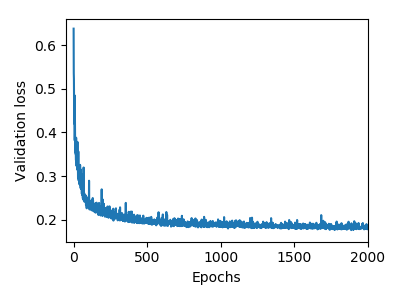

Minimum at 4064 of 4649: 0.173


In [24]:
plt.figure(figsize=(4,3))
plt.plot(valid_loss_vec)
plt.xlabel('Epochs')
plt.ylabel('Validation loss');
plt.xlim(-50, 2000)

min_idx = np.argmin(valid_loss_vec)
min_loss = np.min(valid_loss_vec)
plt.tight_layout()

plt.savefig('../doc/figures/validation_loss.eps')

print('Minimum at {} of {}: {:.3f}'.format(min_idx, len(valid_loss_vec), min_loss))

In [ ]:
np.save('valid_loss_8trellis_epochs', valid_loss_vec)

In [10]:
valid_loss_vec = np.load('../models/final_valid_loss_80_5e-3.npy')

In [ ]:
valid_loss_vec = np.load('../jupyter/').tolist()

## Load trained parameters

In [35]:
# model.load_state_dict(torch.load('../models/mb_ballroom_bs-100_fold-0.pt', map_location=device))

## Appendix

## TCN

In [9]:
input_size = 120
output_size = 2
nhid = 100
levels = 6
kernel_size = 5
dropout = 0.25

model = TCN(input_size, output_size, nhid, levels, kernel_size, dropout).to(device)

print('Number of learnable Parameters: {}'.format(count_parameters(model)))

Number of learnable Parameters: 624702


In [49]:
# Trellis net

ninp = 120
nhid = 120
nout = 2
nlevels = 11 
kernel_size  = 2
dilation = [1, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
dropout = 0.1
dropouti = 0.1
dropouth = 0.29
dropoutl = 0.0
emb_dropout = 0.02
wdrop = 0.26
temporalwdrop = True
repack = False
wnorm = True
aux = 0
aux_frequency = 1e4
n_experts = 0
    
# wdecay = 8e-7
# anneal = 5
# seq_len = 0
# horizon = 140
# log-interval = 100
# when = [220, 350]
# n_experts = 0 

model = TrellisNetModel(ninp, nhid, nout, nlevels, kernel_size, dilation, dropout, 
                        dropouti, dropouth, dropoutl, emb_dropout, wdrop, temporalwdrop, 
                        repack, wnorm, aux, aux_frequency, n_experts)

print('Number of learnable Parameters: {}'.format(count_parameters(model)))

Weight normalization applied
Number of learnable Parameters: 237662
